<a href="https://colab.research.google.com/github/devt287/applied_stat/blob/main/HW8_P4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages("CVThresh")
install.packages("PLRModels")
install.packages("KernSmooth")
library("CVThresh")
library("PLRModels")
library("KernSmooth")
library("ggplot2")
library("splines")

also installing the dependencies ‘wavethresh’, ‘EbayesThresh’





The downloaded binary packages are in
	/var/folders/rr/8v9k_gfs7x92pw275qlk3pwc0000gq/T//RtmpGjwWto/downloaded_packages

The downloaded binary packages are in
	/var/folders/rr/8v9k_gfs7x92pw275qlk3pwc0000gq/T//RtmpGjwWto/downloaded_packages

The downloaded binary packages are in
	/var/folders/rr/8v9k_gfs7x92pw275qlk3pwc0000gq/T//RtmpGjwWto/downloaded_packages


Loading required package: wavethresh

Loading required package: MASS

WaveThresh: R wavelet software, release 4.7.2, installed


Copyright Guy Nason and others 1993-2022


Note: nlevels has been renamed to nlevelsWT


Loading required package: EbayesThresh

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009



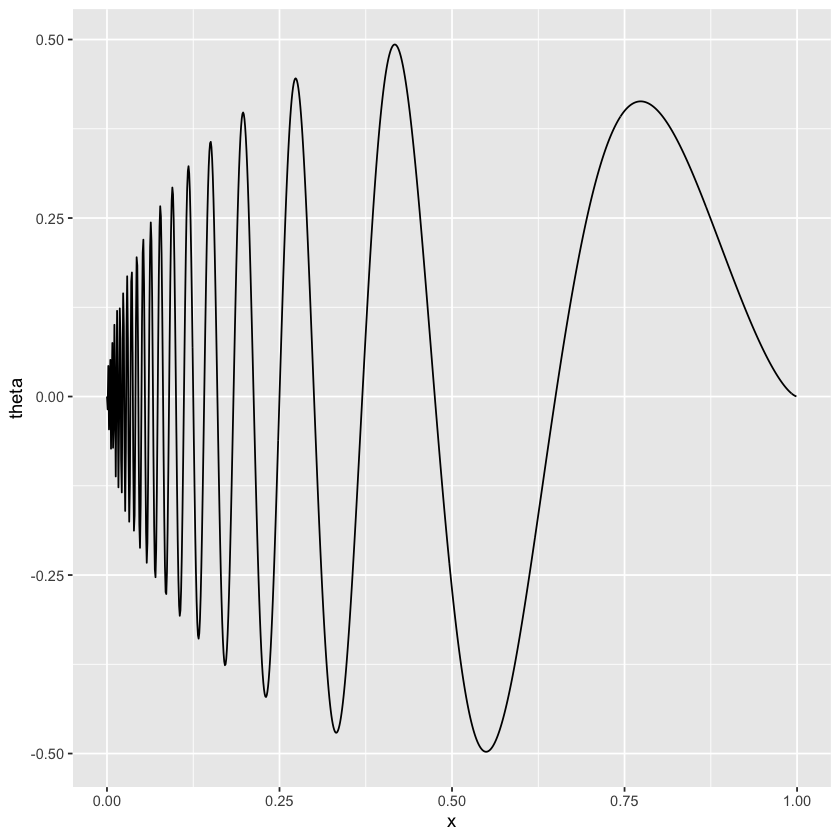

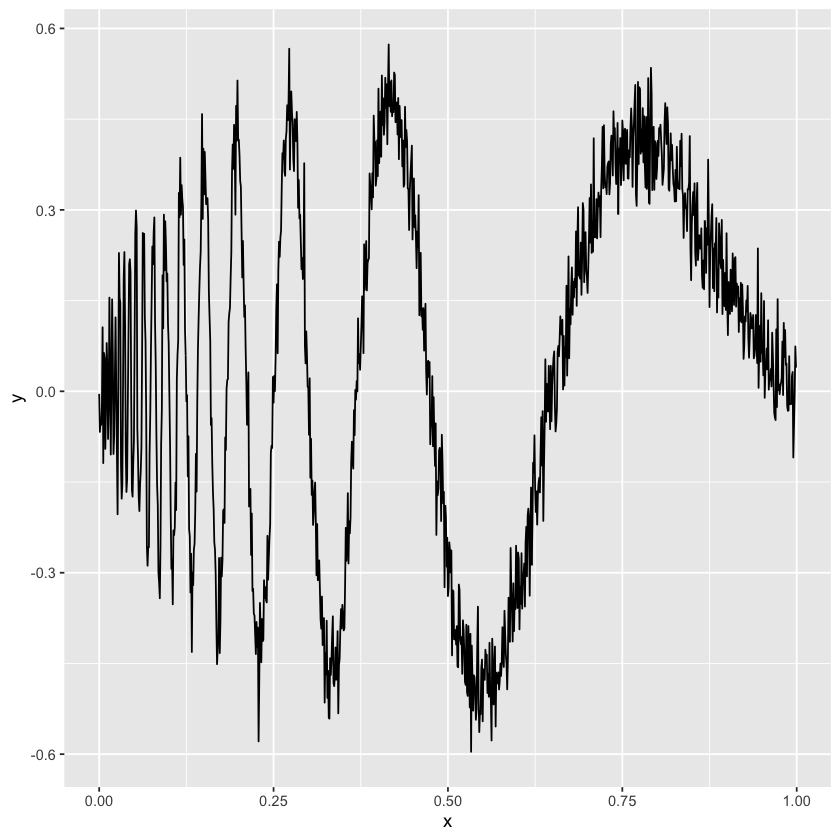

In [2]:
# data generation
set.seed("2023")

n = 1024  # sample size
f = dopp(n)
x = f$x   # values of x
theta = f$meanf  # true values of f(x)
y = rnorm(n, mean = theta, sd = 0.05)   # noisy values y of f(x)
df = data.frame(x,y)

# visualize the data
ggplot(df) + geom_line(aes(x,theta))
ggplot(df) + geom_line(aes(x,y))

[1] 0.001235498


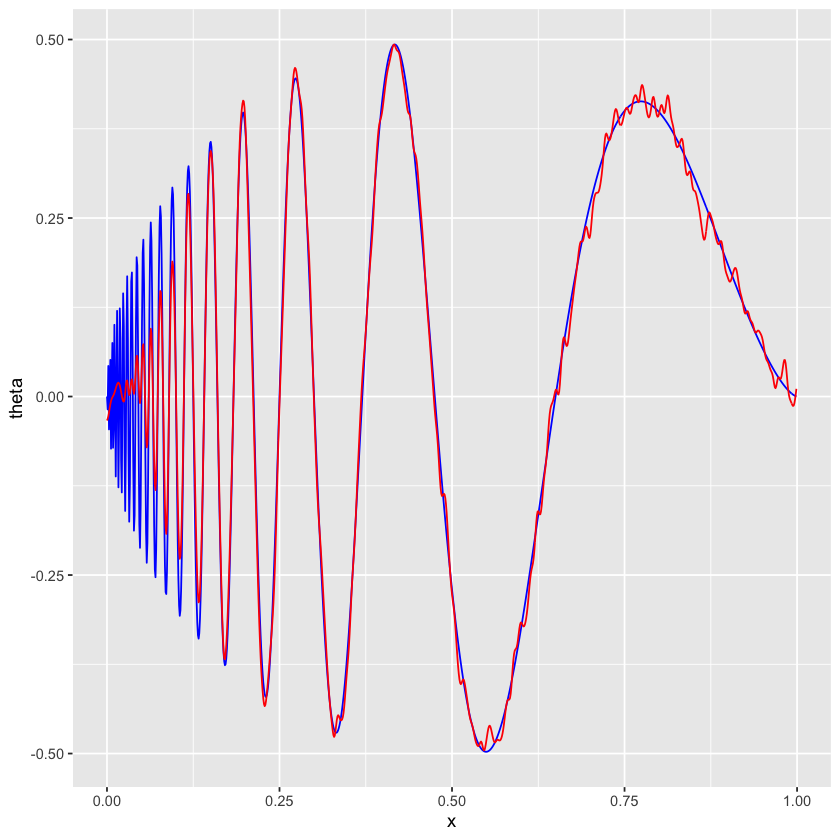

In [6]:
### YOUR CODE (~2 lines): implement the Nadaraya--Watson estimator
# you may use ksmooth() function with a Gaussian kernel
# select a data-driven bandwidth based on the following function:
# dpill: https://search.r-project.org/CRAN/refmans/KernSmooth/html/dpill.html

bandwidth = dpill(x, y)
theta_kernel = ksmooth(x, y, "normal", bandwidth)$y

# Visualization and MSE calculation
ggplot(df) + geom_line(aes(x, theta), color = "blue") +
             geom_line(aes(x, theta_kernel), color = "red")
mse = mean((theta_kernel - theta)^2)
print(mse)

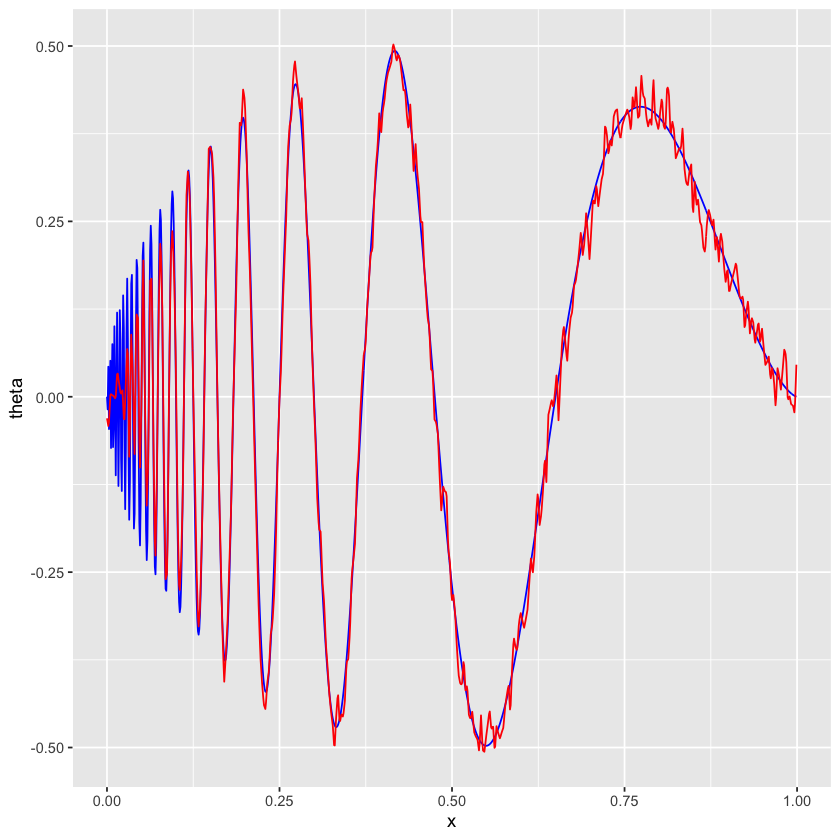

[1] 0.0008461537
[1] 0.001050306


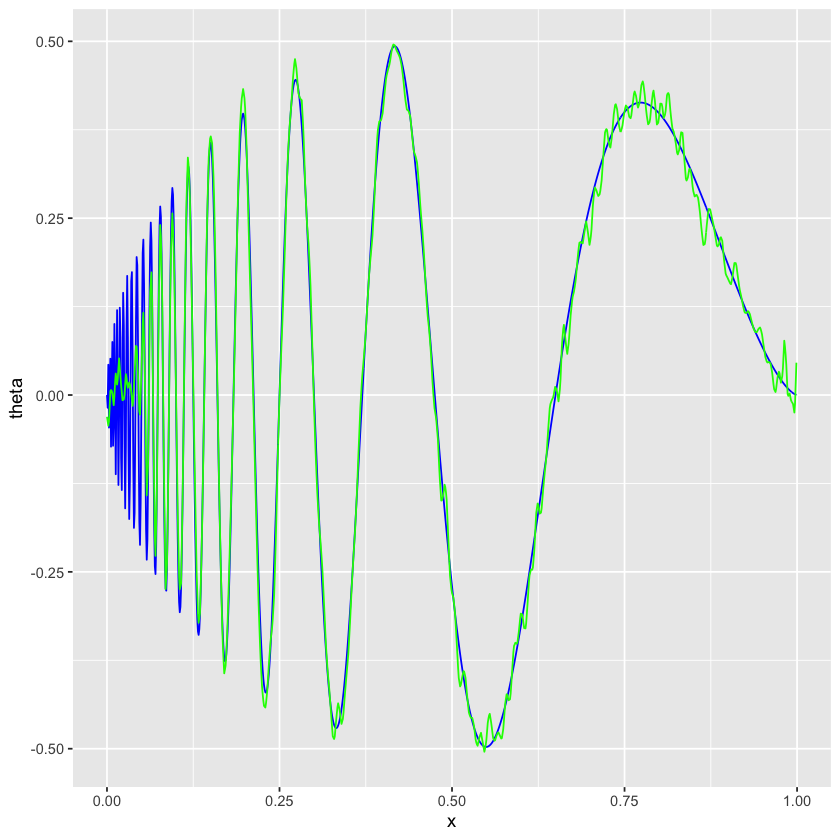

In [13]:
### YOUR CODE (~2 lines): implement the local polynomial regressions
# compute the fits for two sets of hyperparameters
# hyperparameter 1: degree = 1, bandwidth = 0.001
# hyperparameter 2: degree = 20, bandwidth = 0.01
# Gaussian kernel is used in both scenarios
# you may find locpoly() function useful
# you may also play with different bandwidths yourself to see what happens

# Implementing local polynomial regressions
fit_LLR_1 = locpoly(x, y, degree = 1, bandwidth = 0.001, kernel = "normal")
fit_LLR_20 = locpoly(x, y, degree = 20, bandwidth = 0.01, kernel = "normal")

# Interpolate to match the length of original data
theta_LLR_1 = approx(fit_LLR_1$x, fit_LLR_1$y, xout = df$x)$y
theta_LLR_20 = approx(fit_LLR_20$x, fit_LLR_20$y, xout = df$x)$y

# Visualization and MSE calculation
ggplot(df) + 
  geom_line(aes(x, theta), color = "blue") + 
  geom_line(aes(x, theta_LLR_1), col = "red")

ggplot(df) + 
  geom_line(aes(x, theta), color = "blue") + 
  geom_line(aes(x, theta_LLR_20), col = "green")

mse1 = mean((theta_LLR_1 - theta)^2)
mse20 = mean((theta_LLR_20 - theta)^2)
print(mse1)
print(mse20)

Warning message in predict.lm(model, newdata = list(B_splines = B_splines)):
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”


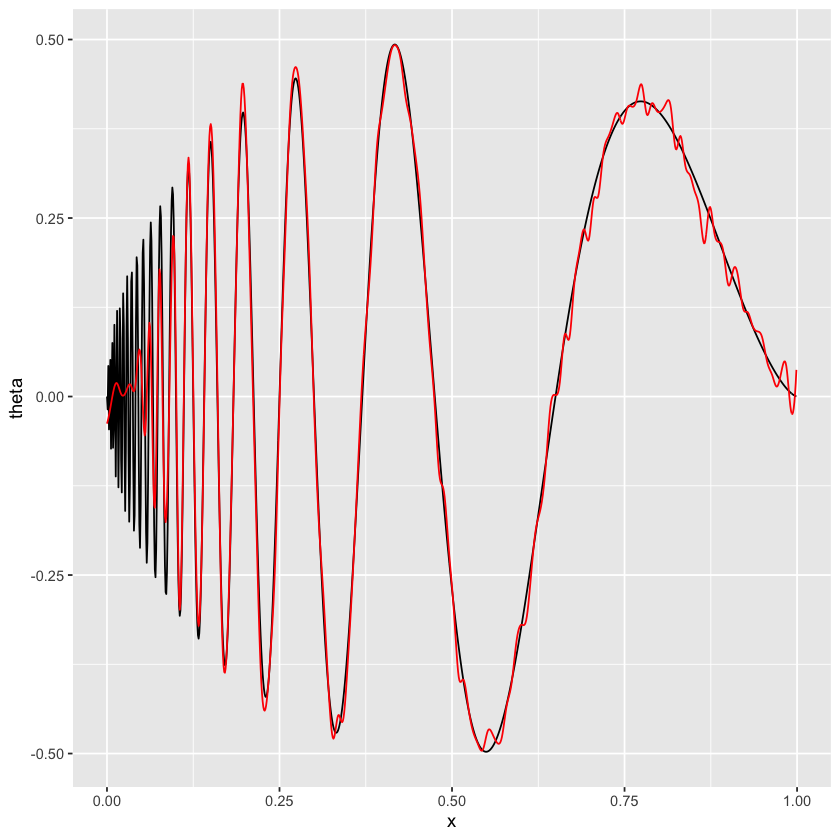

[1] 0.00161096
[1] 0.001311546


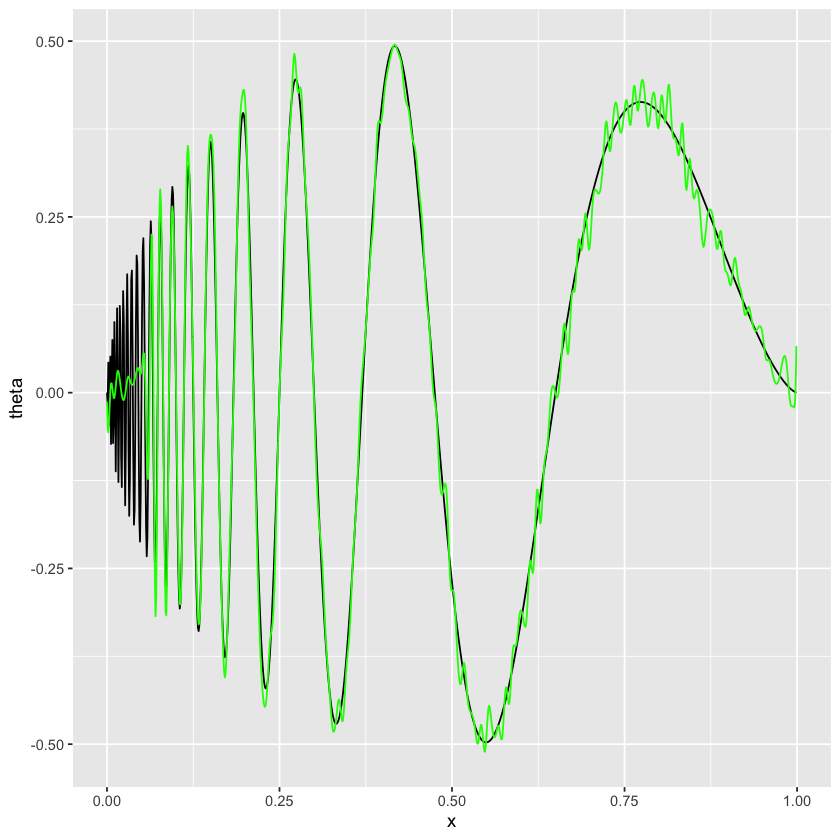

In [8]:
### YOUR CODE: implement the cubic smoothing and regression spline estimates
# for smoothing spline (~1 line): use smooth.spline() and cross validation to
# set the parameters
# for regression spline (~3 lines): use B-spline bs() of degree 3, with knots
# {0, 0.005, ..., 0.995}. Then fit a linear model.

theta_spline_smooth = smooth.spline(x, y, cv = TRUE)$y
knots = seq(0, 1, length.out = 200)  # Adjust the number of knots as necessary
B_splines = bs(x, knots = knots, degree = 3)
model = lm(y ~ B_splines)
theta_spline_reg = predict(model, newdata = list(B_splines = B_splines))

# visualization and MSE
ggplot(df) + geom_line(aes(x, theta)) + geom_line(aes(x, theta_spline_smooth), col = "red")
ggplot(df) + geom_line(aes(x, theta)) + geom_line(aes(x, theta_spline_reg), col = "green")
mse_smooth = mean((theta_spline_smooth - theta)^2)
mse_reg = mean((theta_spline_reg - theta)^2)
print(mse_smooth)
print(mse_reg)

[1] 0.001140976


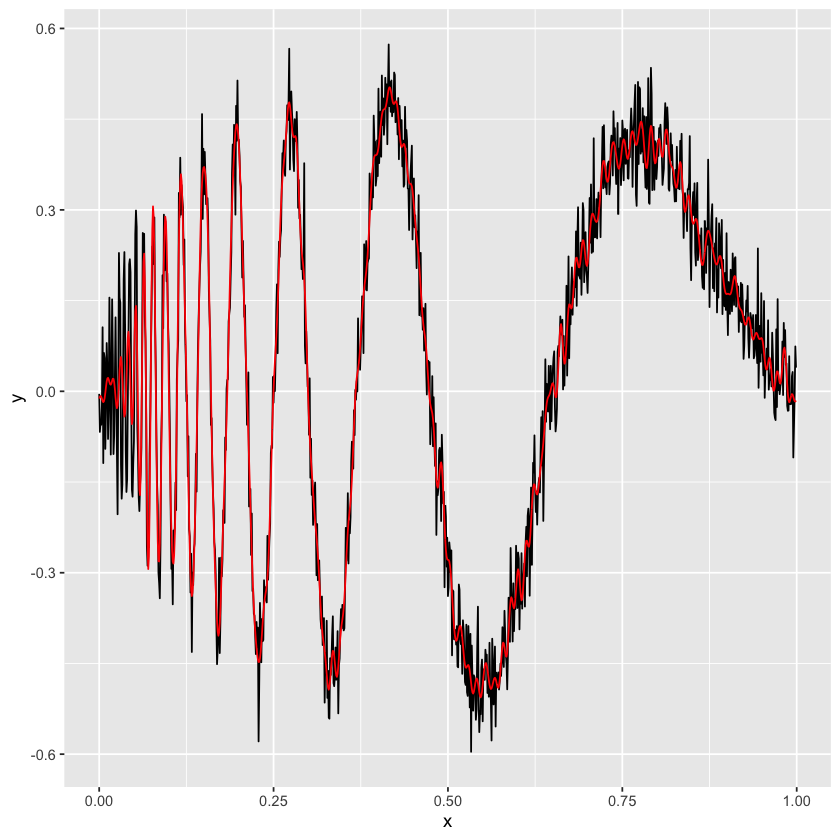

In [9]:
### YOUR CODE (~3 lines): implement the Fourier projection estimator
# use fft() to compute the (inverse) Fourier transform, and
# only keep the first and last 100 coefficients
# Note 1: you may need to normalize your final result by n
# Note 2: for the final plot, you may need to take the real part of complex values

fft_y = fft(y)
n = length(y)
# Zero out all but the first and last 100 coefficients
fft_y[(101:(n-100))] = 0
theta_fft = Re(fft(fft_y, inverse = TRUE) / n)

# Visualization and MSE calculation
ggplot(df, aes(x, y)) + geom_line() + geom_line(aes(x, theta_fft), col = "red")
mse_fft = mean((theta_fft - theta)^2)
print(mse_fft)

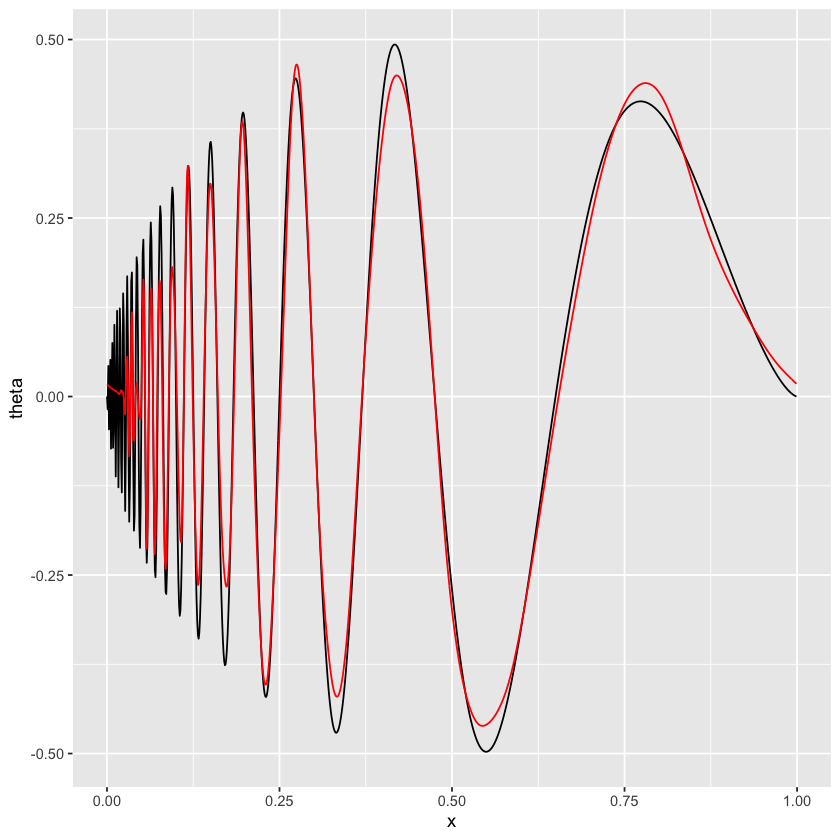

[1] 0.001609768
[1] 0.0006674194


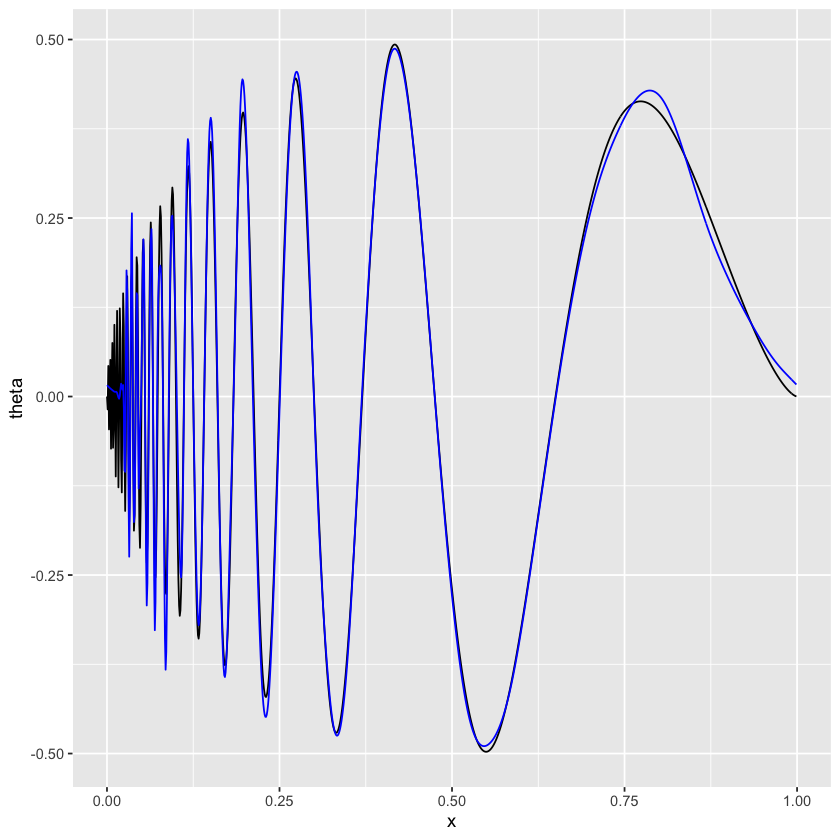

In [11]:
### YOUR CODE (~6 lines): implement the wavelet thresholding estimators
# You should implement both soft and hard thresholding estimators
# the "threshold" function and the examples therein might be useful:
# https://search.r-project.org/CRAN/refmans/wavethresh/html/threshold.wd.html
# you may set policy = "universal" to choose thresholds
library(wavethresh)
wd_y = wd(y)
wd_y_soft = threshold(wd_y, policy = "universal", type = "soft")
theta_WT_soft = wr(wd_y_soft)
wd_y_hard = threshold(wd_y, policy = "universal", type = "hard")
theta_WT_hard = wr(wd_y_hard)

# visualization and MSE
ggplot(df) + geom_line(aes(x, theta)) + geom_line(aes(x, theta_WT_soft), col = "red")
ggplot(df) + geom_line(aes(x, theta)) + geom_line(aes(x, theta_WT_hard), col = "blue")
mse_soft = mean((theta_WT_soft - theta)^2)
mse_hard = mean((theta_WT_hard - theta)^2)
print(mse_soft)
print(mse_hard)

https://colab.research.google.com/github/devt287/applied_stat/blob/main/HW8_P4.ipynb